In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D,MaxPooling3D, Conv3D, Flatten
from tensorflow.keras.models import Sequential
from keras.models import load_model
from faceRecon import FaceExtractorMultithread, FaceExtractor

In [ ]:
from faceRecon import FaceExtractorMultithread, FaceExtractor

def loadData(baseDir):
    videos = []
    labels = []
    # Iterate over the folders of videos inside Celeb-DF-v2
    for folder in os.listdir(baseDir):
        folder_path = os.path.join(baseDir, folder)
        if not os.path.isdir(folder_path):
            continue
        for video in os.listdir(folder_path):
            video_path = os.path.join(folder_path, video)
            videos.append(video_path)
            if (folder.split('-')[1] == 'real'):
                labels.append(1)
            else:
                labels.append(0)

    dataFrame = pd.DataFrame({'video': videos, 'label': labels})

    # Reduce el tamaño del dataset para que sea más fácil de manejar
    dataFrame = dataFrame.sample(20, random_state=42)

    face_extractor = FaceExtractorMultithread(n=30, max_workers=5)
    print('Extracting faces from videos...')
    dataFrame= face_extractor.transform(dataFrame)
    return dataFrame


df = loadData(baseDir='Datasets\CelebDB\Celeb-DF-v2')

print('Dividing dataset into train and test...')
# Dividir el dataset en train y test
X = df.drop(['label'], axis = 1)
y = df['label']


#comprobar tamaños 
print(X.shape)
print(y.shape)

In [ ]:
def loadData(baseDir):
    videos = []
    labels = []
    # Iterate over the folders of videos inside Celeb-DF-v2
    for folder in os.listdir(baseDir):
        folder_path = os.path.join(baseDir, folder)
        if not os.path.isdir(folder_path):
            continue
        for video in os.listdir(folder_path):
            video_path = os.path.join(folder_path, video)
            videos.append(video_path)
            if (folder.split('-')[1] == 'real'):
                labels.append(1)
            else:
                labels.append(0)

    dataFrame = pd.DataFrame({'video': videos, 'label': labels})

    # Reduce el tamaño del dataset para que sea más fácil de manejar
    dataFrame = dataFrame.sample(10, random_state=42)

    face_extractor = FaceExtractor(n=30)
    print('Extracting faces from videos...')
    dataFrame= face_extractor.transform(dataFrame)
    return dataFrame


df = loadData(baseDir='Datasets\CelebDB\Celeb-DF-v2')

print('Dividing dataset into train and test...')
# Dividir el dataset en train y test
X = df.drop(['label'], axis = 1)
y = df['label']

#comprobar tamaños 
print(X.shape)
print(y.shape)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify = y)
X_train = np.stack(X_train['face'], axis=0)
X_test = np.stack(X_test['face'], axis=0)


In [ ]:
X_train

In [ ]:

model = Sequential()
model.add(Input(shape=(64, 64, 3)))
model.add(Lambda(lambda x: x/255.0)) #normalizamos los valores de los pixeles
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='softmax'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print('Started training...')

model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

#evaluamos el modelo
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)
print('Test Loss: %.3f' % loss)

#exportamos el modelo
model.save('model.h5')


# Carga de modelo y metricas
Carga el modelo y comprueba todas las métricas para compararlos

In [ ]:
#importamos el modelo y lo evaluamos con varias metricas
model = load_model(filepath=r'C:\Users\pablo\Desktop\model_full_dataset.h5')



In [ ]:
#evaluamos el modelo 
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)
print('Test Loss: %.3f' % loss)
# evaluamos el modelo usando todo tipo de metricas
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))    
print(confusion_matrix(y_test, y_pred))


# Guardado de dataframes
Guardado de dataframes de panda en un formato que permite guardar e importar mucha información de forma eficiente.

In [ ]:
#test to save and to restore dataframe
%pip install tables
df.to_hdf('dataframe.h5', key='df', mode='w')
del df


In [ ]:
df = pd.read_hdf('dataframe.h5', 'df')
df.describe()

# Comprobar que el face extractor trabaja correctamente
En este snippet pruebo en el caso de un solo video a ver si procesa bien las caras y pone las etiquetas bien

In [ ]:
extractor = FaceExtractor(n=30,output_dir='./imgs')
#creamos un dataset con unicamente un video Datasets\CelebDB\Celeb-DF-v2\Celeb-real\id0_0000.mp4
df = pd.DataFrame({'video': ['Datasets\CelebDB\Celeb-DF-v2\Celeb-real\id0_0000.mp4'], 'label': [1]})
df = extractor.transform(df)

#comprobamos los datos del df
df

# Sacar el dataframe


In [3]:
def loadData(baseDir):
    videos = []
    labels = []
    # Iterate over the folders of videos inside Celeb-DF-v2
    for folder in os.listdir(baseDir):
        folder_path = os.path.join(baseDir, folder)
        if not os.path.isdir(folder_path):
            continue
        for video in os.listdir(folder_path):
            video_path = os.path.join(folder_path, video)
            videos.append(video_path)
            if (folder.split('-')[1] == 'real'):
                labels.append(1)
            else:
                labels.append(0)
    dataFrame = pd.DataFrame({'video': videos, 'label': labels})

    # Reduce el tamaño del dataset para que sea más fácil de manejar
    #dataFrame = dataFrame.sample(1, random_state=42)

    face_extractor = FaceExtractorMultithread(n=10)
    print('Extracting faces from videos...')
    dataFrame= face_extractor.transform(dataFrame)
    return dataFrame


df = loadData(baseDir='Datasets\CelebDB\Celeb-DF-v2')
df.to_hdf('dataframe.h5', key='df', mode='w')

Extracting faces from videos...
Processing video 1/6529 ----> 0%
Processing video 2/6529 ----> 0%
Processing video 3/6529 ----> 0%
Processing video 4/6529 ----> 0%
Processing video 5/6529 ----> 0%
Processing video 6/6529 ----> 0%
Processing video 7/6529 ----> 0%
Processing video 8/6529 ----> 0%
Processing video 9/6529 ----> 0%
Processing video 10/6529 ----> 0%
Processing video 11/6529 ----> 0%
Processing video 12/6529 ----> 0%
Processing video 13/6529 ----> 0%
Processing video 14/6529 ----> 0%
Processing video 15/6529 ----> 0%
Processing video 16/6529 ----> 0%
Processing video 17/6529 ----> 0%
Processing video 18/6529 ----> 0%
Processing video 19/6529 ----> 0%
Processing video 20/6529 ----> 0%
Processing video 21/6529 ----> 0%
Processing video 22/6529 ----> 0%
Processing video 23/6529 ----> 0%
Processing video 24/6529 ----> 0%
Processing video 25/6529 ----> 0%
Processing video 26/6529 ----> 0%
Processing video 27/6529 ----> 0%
Processing video 28/6529 ----> 0%
Processing video 29/6529 

: 

# Number of deepfakes and not deepfakes

In [12]:
from sklearn.utils import shuffle
from MetricsModule import TrainingMetrics


print('Loading data...')
fragments =[ pd.read_hdf(f'dataframes/CelebDB/dataframe{i}_1200videos.h5', key=f'df{i}') for i in range(6)]
df = pd.concat(fragments)
df = shuffle(df)


#count number of 1s and 0s in the label column
df['label'].value_counts()

Loading data...


label
0    19081
1     3531
Name: count, dtype: int64

# Whole module

In [2]:
from sklearn.utils import shuffle
from MetricsModule import TrainingMetrics
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D,MaxPooling3D, Conv3D, Flatten,Lambda, Dropout
from tensorflow.keras.models import Sequential
from keras.models import load_model
from faceRecon import FaceExtractorMultithread, FaceExtractor


route = 'P:\TFG\Datasets\dataframes_test'

print('Loading dataframes...')
fragments = []
for i in range(5):
    # Assuming each dataframe is stored as a separate table in the HDF5 file
    chunk = pd.read_hdf(f'{route}\dataframe{i}_FaceForensics.h5', key=f'df{i}')
    fragments.append(chunk)
#fragments = [pd.read_hdf(f'dataframes/CelebDB/dataframe{i}_600videos.h5', key=f'df{i}') for i in range(2)]#6
df = pd.concat(fragments)

print(df.describe())
print(df.dtypes)

X = df.drop(['label'], axis = 1)
y = df['label']

print('Dividing dataset into train and test...')
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify = y)
X_train = np.stack(X_train['face'], axis=0)
X_test = np.stack(X_test['face'], axis=0)

Loading dataframes...
        label
count  6845.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
face     object
label     int64
dtype: object
Dividing dataset into train and test...


In [3]:
X_test

array([[[[ 70,  77,  83],
         [ 75,  79,  88],
         [ 76,  79,  90],
         ...,
         [198, 193, 192],
         [199, 194, 193],
         [202, 194, 194]],

        [[ 63,  70,  76],
         [ 70,  77,  83],
         [ 66,  70,  79],
         ...,
         [198, 193, 192],
         [199, 194, 193],
         [202, 194, 194]],

        [[ 65,  72,  78],
         [ 67,  74,  80],
         [ 66,  70,  79],
         ...,
         [200, 192, 192],
         [201, 193, 193],
         [202, 194, 194]],

        ...,

        [[ 33,  25,  27],
         [ 31,  21,  23],
         [ 25,  17,  19],
         ...,
         [187, 184, 183],
         [188, 185, 184],
         [192, 188, 184]],

        [[ 30,  22,  24],
         [ 30,  20,  22],
         [ 25,  17,  19],
         ...,
         [187, 184, 183],
         [188, 185, 184],
         [192, 188, 184]],

        [[ 29,  21,  23],
         [ 25,  16,  20],
         [ 22,  14,  16],
         ...,
         [187, 184, 183],
        

In [9]:
print('Creating model...')
model = Sequential()
model.add(Input(shape=(100, 100, 3)))
model.add(Lambda(lambda x: x/255.0)) #normalizamos los valores de los pixeles
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='softmax'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


Creating model...


Started training....
Epoch 1/2
172/172 [==============================] - 3s 17ms/step - loss: 4.2959e-10 - accuracy: 1.0000 - val_loss: 6.0351e-11 - val_accuracy: 1.0000
Epoch 2/2
172/172 [==============================] - 3s 17ms/step - loss: 4.2781e-10 - accuracy: 1.0000 - val_loss: 6.0047e-11 - val_accuracy: 1.0000
Training time: 5.9637532234191895 seconds
CPU usage: 16.233333333333334%
Memory usage: 58.61666666666667%


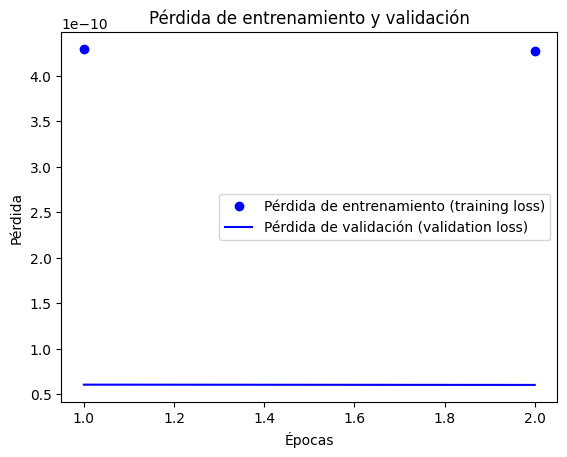

43/43 [==============================] - 0s 6ms/step


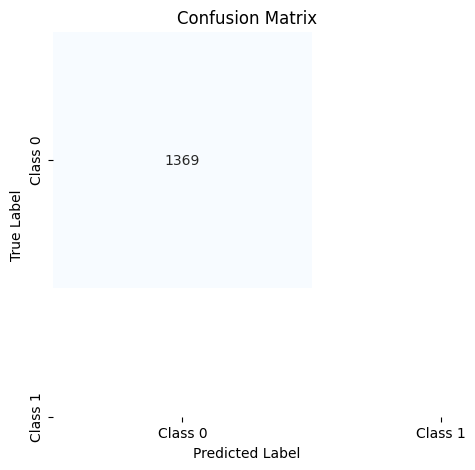

In [12]:
from MetricsModule import TrainingMetrics
#prueba de que imprime las stats
metrics = TrainingMetrics(model)
metrics.train(X_train, y_train, X_test, y_test, epochs=2)